# Proyecto entrega 1

### Integrantes
* Santiago Gomez
* Sebastian Martinez
* Johan Suarez

### Grupo
36

## Carga de datos

In [36]:
%pip install -U "spacy>=3.8,<3.9"
%pip install "./es_core_news_sm-3.8.0-py3-none-any.whl" 
%pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Processing c:\users\sebastian\onedrive\escritorio\uni\bi\proyectos\p1\es_core_news_sm-3.8.0-py3-none-any.whl
es-core-news-sm is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

vectorizer = TfidfVectorizer()
nlp = spacy.load("es_core_news_sm")
dfOriginal = pd.read_excel('Datos_proyecto.xlsx')
dfOriginal.info()
target_names = dfOriginal['labels'].unique()
print("Categorías encontradas:", target_names)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB
Categorías encontradas: [4 3 1]


## Exploración del texto

Principalmente observemos el formato inicial del dataset, con especial enfasis en la columna de textos

In [38]:
target_names =  {1:'ODS 1',3:'ODS 3',4:'ODS 4'}
dfOriginal.head()
df = dfOriginal.copy()
df['textos'] = df['textos'].astype("string")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   string
 1   labels  2424 non-null   int64 
dtypes: int64(1), string(1)
memory usage: 38.0 KB


### Exploracion de longitudes de los textos presentados en el dataset

In [39]:
def columnasConteo(df : pd.DataFrame):
    df['Conteo'] = [len(x) for x in df['textos']]
    df['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in df['textos']]
    df['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in df['textos']]
columnasConteo(df)
df.head()

,textos,labels,Conteo,Max,Min
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,352,14,1
1,Para los niños más pequeños (bebés y niños peq...,4,516,16,1
2,"Además, la formación de especialistas en medic...",3,659,15,1
3,En los países de la OCDE se tiende a pasar de ...,4,693,18,1
4,Este grupo se centró en las personas que padec...,3,608,14,0


Veamos ahora los maximos, minimos y promedio de la longitud de los textos del dataset

In [40]:
def longitud(df: pd.DataFrame):
    maximo = df['Conteo'].max()
    minimo = df['Conteo'].min()
    promedio = int(df['Conteo'].mean())
    print(f'El maximo de longitud es: {maximo}')
    print(f'El minimo de longitud es: {minimo}')
    print(f'El promedio de longitud es: {promedio:.2f}')
    return maximo, minimo, promedio

El maximo de longitud es: 1492
El minimo de longitud es: 303
El promedio de longitud es: 683.00


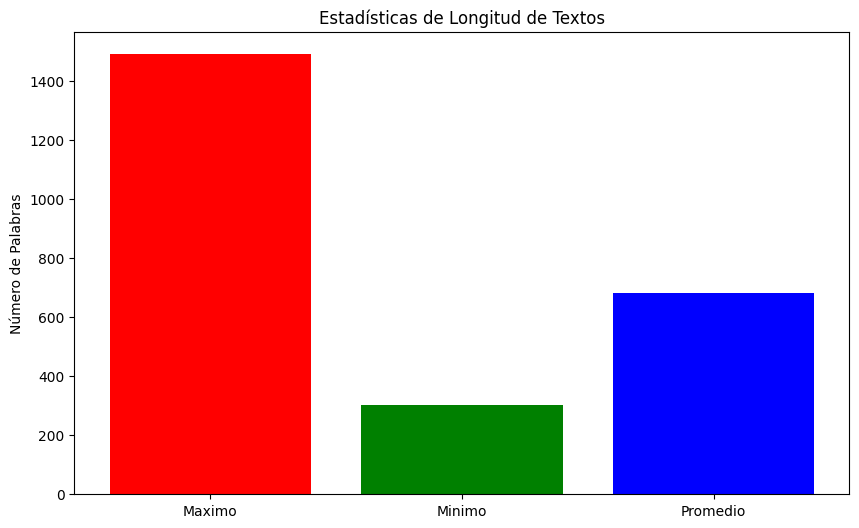

In [41]:
maximo, minimo, promedio = longitud(df)
plt.figure(figsize=(10,6))
plt.bar(['Maximo', 'Minimo', 'Promedio'], [maximo, minimo, promedio], color=['red', 'green', 'blue'])
plt.title('Estadísticas de Longitud de Textos')
plt.ylabel('Número de Palabras')
plt.show()


### Distribucion de la longitud

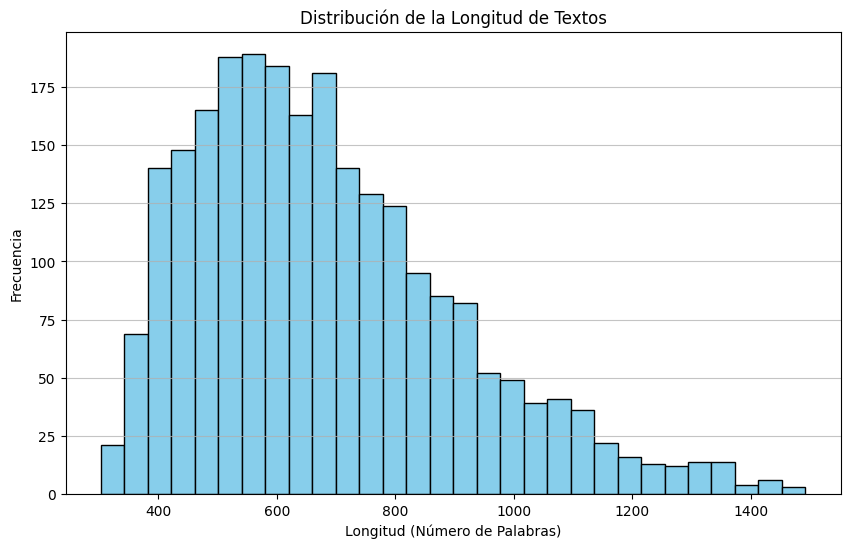

In [42]:

plt.figure(figsize=(10,6))
plt.hist(df['Conteo'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de la Longitud de Textos')
plt.xlabel('Longitud (Número de Palabras)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()

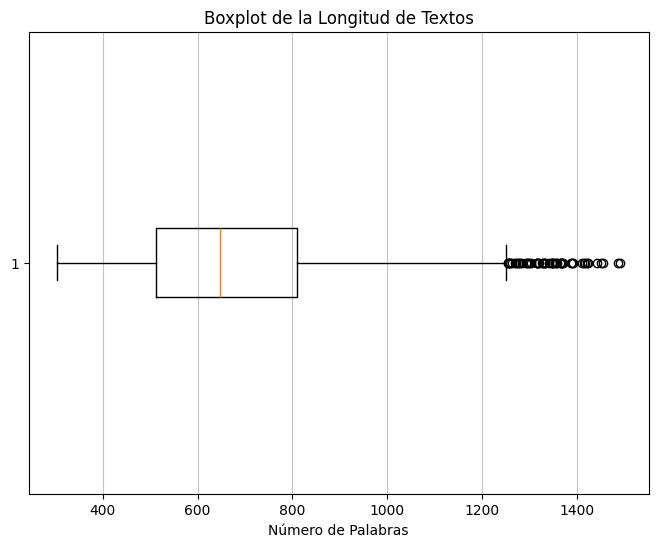

In [43]:
#Boxplot
plt.figure(figsize=(8,6))
plt.boxplot(df['Conteo'], vert=False)
plt.title('Boxplot de la Longitud de Textos')
plt.xlabel('Número de Palabras')
plt.grid(axis='x', alpha=0.75)
plt.show()

### Presencia de catracteres especiales

In [44]:
def especiales(df : pd.DataFrame):
    signos = r"(?:[!¡¿?;:'\"]|\.{3})"
    signosPresentes = df['textos'].str.contains(signos).sum()
    print(f'La cantidad de textos con signos de puntuación es: {signosPresentes}')
    print(f'El porcentaje de textos con signos de puntuación es: {signosPresentes/len(df)*100:.2f}%')
    especiales = r"(?:[@#$%^&*()_+=\[\]{}|\\<>/~`])"
    especialesPresentes = df['textos'].str.contains(especiales).sum()
    print(f'La cantidad de textos con caracteres especiales es: {especialesPresentes}')
    print(f'El porcentaje de textos con caracteres especiales es: {especialesPresentes/len(df)*100:.2f}%')
    return signosPresentes, especialesPresentes


La cantidad de textos con signos de puntuación es: 596
El porcentaje de textos con signos de puntuación es: 24.59%
La cantidad de textos con caracteres especiales es: 1562
El porcentaje de textos con caracteres especiales es: 64.44%


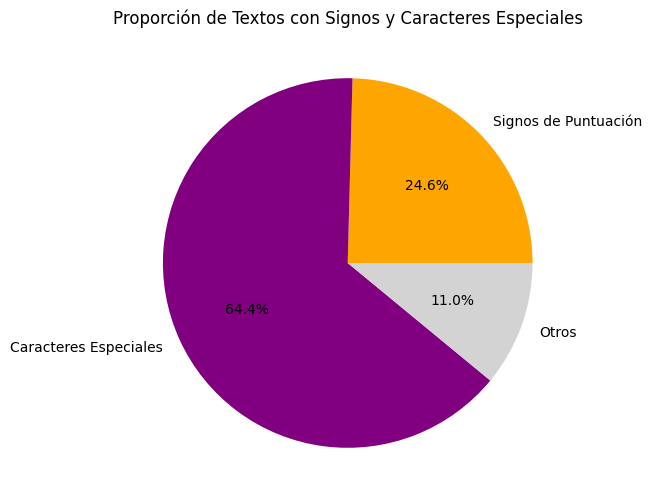

In [45]:
#Distribucion especiales
size = df['textos'].size
signosPresentes, especialesPresentes = especiales(df)
plt.figure(figsize=(8,6))
plt.pie([signosPresentes, especialesPresentes, size - signosPresentes - especialesPresentes], labels=['Signos de Puntuación', 'Caracteres Especiales', 'Otros'], autopct='%1.1f%%', colors=['orange', 'purple', 'lightgray'])
plt.title('Proporción de Textos con Signos y Caracteres Especiales')
plt.show()


### Distribucion de labels

,conteo
ODS 1,505
ODS 3,894
ODS 4,1025


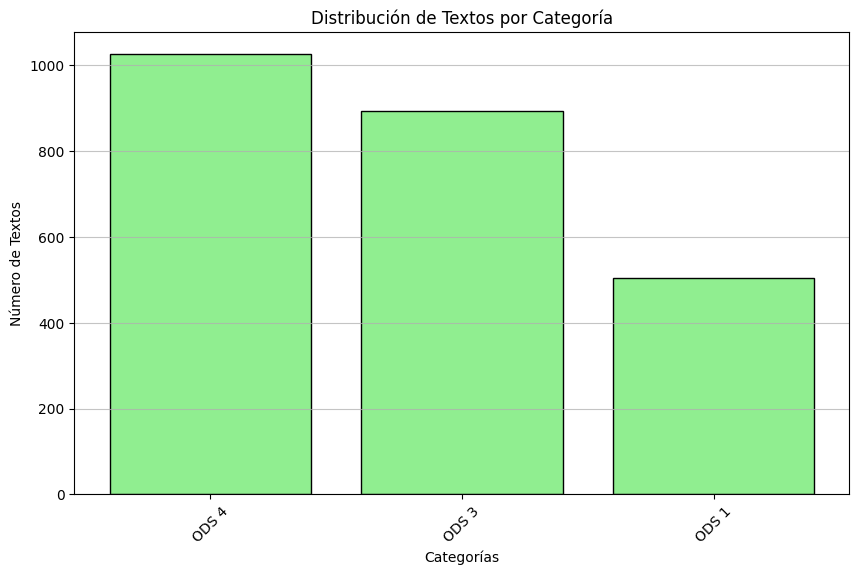

In [46]:
class_counts = df['labels'].value_counts().sort_index()
class_counts.index = [target_names[i] for i in class_counts.index]
display(class_counts.to_frame('conteo'))

label_counts = df['labels'].value_counts()
plt.figure(figsize=(10,6))
plt.bar(label_counts.index.map(target_names), label_counts.values, color='lightgreen', edgecolor='black')
plt.title('Distribución de Textos por Categoría')
plt.xlabel('Categorías')
plt.ylabel('Número de Textos')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()


<Figure size 1000x600 with 0 Axes>

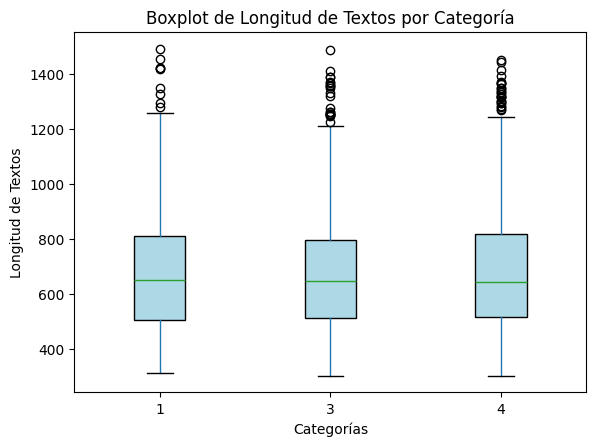

In [47]:
#Boxplot por categoria
plt.figure(figsize=(10,6))
df.boxplot(column='Conteo', by='labels', grid=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Boxplot de Longitud de Textos por Categoría')
plt.suptitle('')  
plt.xlabel('Categorías')
plt.ylabel('Longitud de Textos')
plt.show()

### Limpieza

Procedemos a poner todo el dataset en un único formato

In [48]:
def todoAmin(df: pd.DataFrame):
    df['textos'] = df['textos'].str.lower()
todoAmin(df)
df.head()

,textos,labels,Conteo,Max,Min
0,"""aprendizaje"" y ""educación"" se consideran sinó...",4,352,14,1
1,para los niños más pequeños (bebés y niños peq...,4,516,16,1
2,"además, la formación de especialistas en medic...",3,659,15,1
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1
4,este grupo se centró en las personas que padec...,3,608,14,0


Limpieza de caracteres especiales, signos y urls

In [49]:
def limpiza(df: pd.DataFrame):
    df['textos'] = df['textos'].str.replace(r"http[s]?://[^\s)]+", '', regex=True)
    df['textos'] = df['textos'].str.replace(r"(?:[!¡¿?;:'\".,]|\.{3})", '', regex=True)
    df['textos'] = df['textos'].str.replace(r"(?:[@#$%^&*()_+=\[\]{}|\\<>/~`])", '', regex=True)
    df['textos'] = df['textos'].str.replace(r"\s+", ' ', regex=True).str.strip()
limpiza(df)
df.head()


,textos,labels,Conteo,Max,Min
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1
2,además la formación de especialistas en medici...,3,659,15,1
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1
4,este grupo se centró en las personas que padec...,3,608,14,0


### Duplicados y Nulos

In [50]:
def verNulosYDuplicados(df: pd.DataFrame):
    print("Valores nulos por columna:")
    display(df.isnull().sum())
    print("\nDuplicados (filas completas):", df.duplicated().sum())
    const_cols = [c for c in df.columns if df[c].nunique() == 1]
    print("Columnas constantes:", const_cols if const_cols else "Ninguna")
verNulosYDuplicados(df)


Valores nulos por columna:


textos    0
labels    0
Conteo    0
Max       0
Min       0
dtype: int64


Duplicados (filas completas): 0
Columnas constantes: Ninguna


### Tokenización

In [51]:
def tokenizacion(df: pd.DataFrame):
    columnaTokens = []
    for opinion in df['textos']:
        columnaTokens.append(opinion.split())
    df['tokens'] = columnaTokens
    return df
doc = tokenizacion(df)   
df.head()

,textos,labels,Conteo,Max,Min,tokens
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1,"[aprendizaje, y, educación, se, consideran, si..."
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1,"[para, los, niños, más, pequeños, bebés, y, ni..."
2,además la formación de especialistas en medici...,3,659,15,1,"[además, la, formación, de, especialistas, en,..."
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1,"[en, los, países, de, la, ocde, se, tiende, a,..."
4,este grupo se centró en las personas que padec...,3,608,14,0,"[este, grupo, se, centró, en, las, personas, q..."


### Eliminación de tockens innecesarios, articulos, preposiciones, etc.

In [52]:
def quitar_stopwords(df: pd.DataFrame):
    stopwords = nlp.Defaults.stop_words
    tokens_sin_stopwords = []
    
    for lista in df['tokens']:
        tokens_filtrados = [tok for tok in lista if tok.lower() not in stopwords]
        tokens_sin_stopwords.append(tokens_filtrados)
    
    df['tokens_sin_innecesarios'] = tokens_sin_stopwords

quitar_stopwords(df)
df.head()


,textos,labels,Conteo,Max,Min,tokens,tokens_sin_innecesarios
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1,"[aprendizaje, y, educación, se, consideran, si...","[aprendizaje, educación, consideran, sinónimos..."
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1,"[para, los, niños, más, pequeños, bebés, y, ni...","[niños, pequeños, bebés, niños, pequeños, capa..."
2,además la formación de especialistas en medici...,3,659,15,1,"[además, la, formación, de, especialistas, en,...","[formación, especialistas, medicina, general, ..."
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1,"[en, los, países, de, la, ocde, se, tiende, a,...","[países, ocde, tiende, pasar, cursos, obligato..."
4,este grupo se centró en las personas que padec...,3,608,14,0,"[este, grupo, se, centró, en, las, personas, q...","[grupo, centró, personas, padecen, trastornos,..."


### Lematización

In [53]:
def lematizar_tokens(df: pd.DataFrame):
    lemas = []
    for lista in df['tokens_sin_innecesarios']:

        texto = " ".join(lista)
        doc = nlp(texto)
        lemas.append([token.lemma_ for token in doc if not token.is_punct and not token.is_space])
    
    df['lematizados'] = lemas
    return df

df = lematizar_tokens(df)
df.head()

,textos,labels,Conteo,Max,Min,tokens,tokens_sin_innecesarios,lematizados
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1,"[aprendizaje, y, educación, se, consideran, si...","[aprendizaje, educación, consideran, sinónimos...","[aprendizaje, educación, considerar, sinónir, ..."
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1,"[para, los, niños, más, pequeños, bebés, y, ni...","[niños, pequeños, bebés, niños, pequeños, capa...","[niño, pequeño, bebé, niño, pequeño, capacitac..."
2,además la formación de especialistas en medici...,3,659,15,1,"[además, la, formación, de, especialistas, en,...","[formación, especialistas, medicina, general, ...","[formación, especialista, medicín, general, in..."
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1,"[en, los, países, de, la, ocde, se, tiende, a,...","[países, ocde, tiende, pasar, cursos, obligato...","[país, ocde, tender, pasar, curso, obligatorio..."
4,este grupo se centró en las personas que padec...,3,608,14,0,"[este, grupo, se, centró, en, las, personas, q...","[grupo, centró, personas, padecen, trastornos,...","[grupo, centrar, persona, padecer, trastorno, ..."


### Analisis de frecuencia de palabras

In [54]:
def frecuenciasPorPalabra(df: pd.DataFrame, vectorizer=vectorizer):
    textos = [" ".join(tokens) for tokens in df['lematizados']]
    X = vectorizer.fit_transform(textos)
    palabras = vectorizer.get_feature_names_out()
    pesosPromedio = np.asarray(X.mean(axis=0)).ravel()
    freq_df = pd.DataFrame({'Palabra': palabras, 'Peso Promedio': pesosPromedio})
    freq_df = freq_df.sort_values(by='Peso Promedio', ascending=False).reset_index(drop=True)
    return freq_df

freq_df = frecuenciasPorPalabra(df)
freq_df.head(10)


,Palabra,Peso Promedio
0,salud,0.027882
1,educación,0.025477
2,país,0.025256
3,escuela,0.024556
4,atención,0.024052
5,pobreza,0.022993
6,sistema,0.018521
7,año,0.018438
8,nivel,0.018389
9,servicio,0.017348


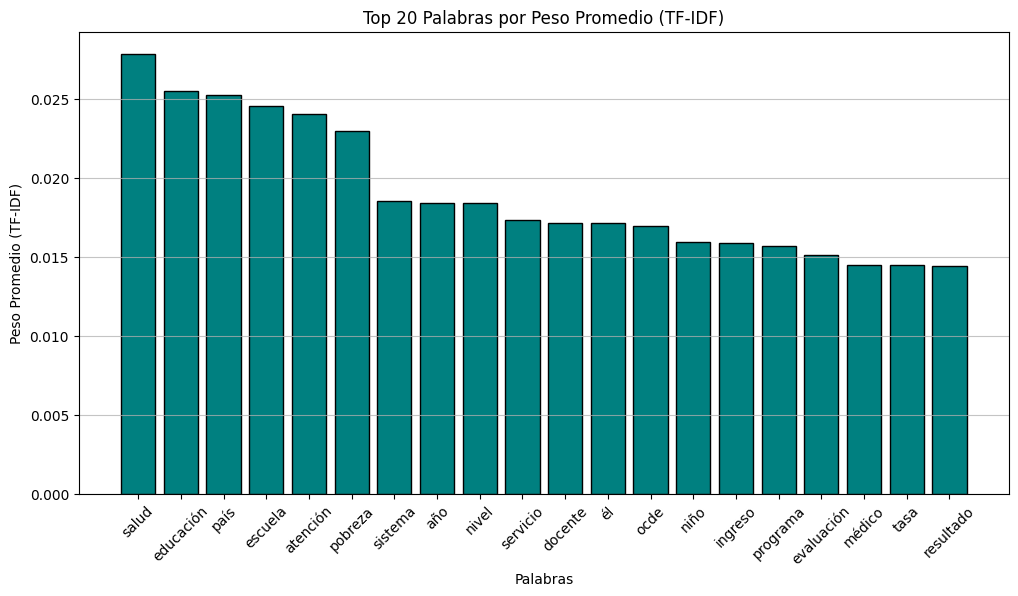

In [55]:
#plot frecuencias
plt.figure(figsize=(12,6))
plt.bar(freq_df['Palabra'][:20], freq_df['Peso Promedio'][:20], color='teal', edgecolor='black')
plt.title('Top 20 Palabras por Peso Promedio (TF-IDF)')
plt.xlabel('Palabras')
plt.ylabel('Peso Promedio (TF-IDF)')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

# Implementación del modelo
Ahora despues de haber analizado los datos y hacer el proceso para mejorar la calidad de estos, empezaremos a hacer el modelo, en este caso haremos uso del algoritmo KNN (K-Nearest Neighbors) para poder clasificar nuestros datos

In [56]:
df.head()

,textos,labels,Conteo,Max,Min,tokens,tokens_sin_innecesarios,lematizados
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1,"[aprendizaje, y, educación, se, consideran, si...","[aprendizaje, educación, consideran, sinónimos...","[aprendizaje, educación, considerar, sinónir, ..."
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1,"[para, los, niños, más, pequeños, bebés, y, ni...","[niños, pequeños, bebés, niños, pequeños, capa...","[niño, pequeño, bebé, niño, pequeño, capacitac..."
2,además la formación de especialistas en medici...,3,659,15,1,"[además, la, formación, de, especialistas, en,...","[formación, especialistas, medicina, general, ...","[formación, especialista, medicín, general, in..."
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1,"[en, los, países, de, la, ocde, se, tiende, a,...","[países, ocde, tiende, pasar, cursos, obligato...","[país, ocde, tender, pasar, curso, obligatorio..."
4,este grupo se centró en las personas que padec...,3,608,14,0,"[este, grupo, se, centró, en, las, personas, q...","[grupo, centró, personas, padecen, trastornos,...","[grupo, centrar, persona, padecer, trastorno, ..."


Para hacer el analisis es necesario unir los tokens lematizados en un solo string por fila, ya que no se puede analizar uno por uno, sino que se analizan todas las palabras juntas

In [57]:
df['lematizados_str'] = df['lematizados'].apply(lambda tokens: ' '.join(tokens))
df.head()

,textos,labels,Conteo,Max,Min,tokens,tokens_sin_innecesarios,lematizados,lematizados_str
0,aprendizaje y educación se consideran sinónimo...,4,352,14,1,"[aprendizaje, y, educación, se, consideran, si...","[aprendizaje, educación, consideran, sinónimos...","[aprendizaje, educación, considerar, sinónir, ...",aprendizaje educación considerar sinónir escol...
1,para los niños más pequeños bebés y niños pequ...,4,516,16,1,"[para, los, niños, más, pequeños, bebés, y, ni...","[niños, pequeños, bebés, niños, pequeños, capa...","[niño, pequeño, bebé, niño, pequeño, capacitac...",niño pequeño bebé niño pequeño capacitación es...
2,además la formación de especialistas en medici...,3,659,15,1,"[además, la, formación, de, especialistas, en,...","[formación, especialistas, medicina, general, ...","[formación, especialista, medicín, general, in...",formación especialista medicín general incluir...
3,en los países de la ocde se tiende a pasar de ...,4,693,18,1,"[en, los, países, de, la, ocde, se, tiende, a,...","[países, ocde, tiende, pasar, cursos, obligato...","[país, ocde, tender, pasar, curso, obligatorio...",país ocde tender pasar curso obligatorio optat...
4,este grupo se centró en las personas que padec...,3,608,14,0,"[este, grupo, se, centró, en, las, personas, q...","[grupo, centró, personas, padecen, trastornos,...","[grupo, centrar, persona, padecer, trastorno, ...",grupo centrar persona padecer trastorno mental...


Asignamos un 20% del dataset para que sea analizado como parte de pruebasm mientras que el 80% se designara netamente en el entrenamiento del modelo con el algoritmo KNN

In [ ]:
X_train1, X_test, yRestante, yTest = train_test_split(df['lematizados_str'], df['labels'], test_size=0.20, random_state=42, stratify=df['labels'])

X_train.shape, X_test.shape

Train: 1696 registros (69.97%)
Validation: 243 registros (10.02%)
Test: 485 registros (20.01%)


Ahora se crea una función que entrena el modelo, imprime unas metricas, siendo la precisión y el ROC AUC del modelo, muestra un reporte de la clasificación con el f1-score, facilitando la evaluación del KNN.

In [59]:
def evaluar_knn(pipeline, X_train, y_train, X_test, y_test, titulo="KNN"):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    y_proba = None
    try:
        y_proba = pipeline.predict_proba(X_test)
    except Exception:
        pass

    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {titulo} ===")
    print("Accuracy (test):", round(acc, 4))

    auc = roc_auc_score(y_test, y_proba, multi_class="ovr")

    print("ROC AUC (test):", round(auc, 4))


    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=[str(c) for c in sorted(set(y_test))]))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set(y_test)))
    fig, ax = plt.subplots(figsize=(5,4))
    disp.plot(ax=ax, colorbar=False)
    plt.title(f"Matriz de confusión — {titulo}")
    plt.show()

    # Curvas ROC solo si quieres verlas en multiclase
    if y_proba is not None and len(set(y_test)) == 2:
        RocCurveDisplay.from_predictions(y_test, y_proba[:,1])
        plt.title(f"Curva ROC — {titulo}")
        plt.show()

Se define el pipeline con TfidfVectorizer para que transforme la columna de lematizados a numeros para poder hacer el analisis bien, se define el knn para el modelo y asi evaluar su rendimiento.


=== KNN ===
Accuracy (test): 0.9465
ROC AUC (test): 0.9836

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.91      0.96      0.93        51
           3       0.96      0.96      0.96        89
           4       0.96      0.93      0.95       103

    accuracy                           0.95       243
   macro avg       0.94      0.95      0.94       243
weighted avg       0.95      0.95      0.95       243



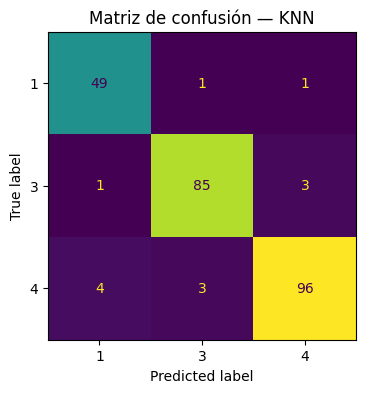

In [ ]:
pipe_knn = Pipeline([
    ("tfidf", TfidfVectorizer()), 
    ("knn", KNeighborsClassifier())
])

evaluar_knn(pipe_knn, X_train, y_train, X_test, y_test, titulo="KNN")

Aca experimentamos con diferentes distancias para identificar cual de estas se adapta mejor al modelo planteado


=== KNN Distancia Euclídea (p=2) ===
Accuracy (test): 0.9546
ROC AUC (test): 0.9929

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.91      0.95      0.93       101
           3       0.96      0.96      0.96       179
           4       0.97      0.95      0.96       205

    accuracy                           0.95       485
   macro avg       0.95      0.95      0.95       485
weighted avg       0.96      0.95      0.95       485



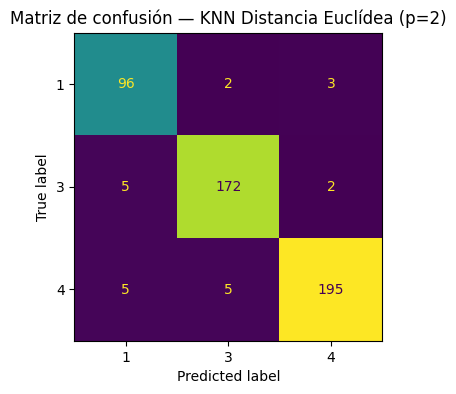


=== KNN Distancia Manhattan (p=1) ===
Accuracy (test): 0.5897
ROC AUC (test): 0.7357

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.88      0.14      0.24       101
           3       0.74      0.45      0.56       179
           4       0.53      0.93      0.68       205

    accuracy                           0.59       485
   macro avg       0.71      0.51      0.49       485
weighted avg       0.68      0.59      0.54       485



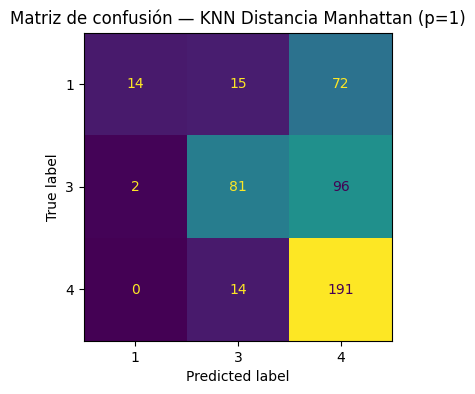


=== KNN Distancia Coseno ===
Accuracy (test): 0.9546
ROC AUC (test): 0.9929

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.91      0.95      0.93       101
           3       0.96      0.96      0.96       179
           4       0.97      0.95      0.96       205

    accuracy                           0.95       485
   macro avg       0.95      0.95      0.95       485
weighted avg       0.96      0.95      0.95       485



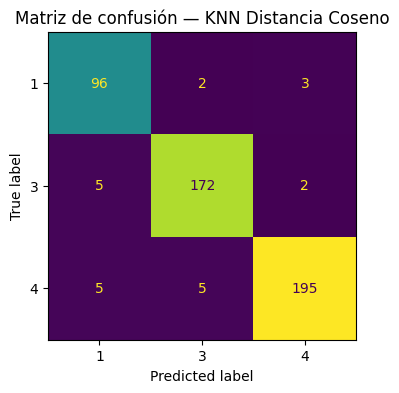

In [81]:
pipe_euclid = Pipeline([("tfidf", TfidfVectorizer()), ("knn", KNeighborsClassifier(metric="minkowski", p=2))])

pipe_manhat = Pipeline([("tfidf", TfidfVectorizer()), ("knn", KNeighborsClassifier(metric="minkowski", p=1))])

pipe_cosine = Pipeline([("tfidf", TfidfVectorizer()), ("knn", KNeighborsClassifier(metric="cosine"))])


evaluar_knn(pipe_euclid, X_train, y_train, X_test, y_test, titulo="KNN Distancia Euclídea (p=2)")
evaluar_knn(pipe_manhat, X_train, y_train, X_test, y_test, titulo="KNN Distancia Manhattan (p=1)")
evaluar_knn(pipe_cosine, X_train, y_train, X_test, y_test, titulo="KNN Distancia Coseno")

Se fija el valor de los n vecinos mas cercanos como 13, siendo este el mejor valor encontrado tras varias pruebas que no se presentan dentro de este archivo.


=== KNN k=13 (mejor modelo encontrado) ===
Accuracy (test): 0.9383
ROC AUC (test): 0.9924

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.89      0.98      0.93        51
           3       0.94      0.93      0.94        89
           4       0.96      0.92      0.94       103

    accuracy                           0.94       243
   macro avg       0.93      0.95      0.94       243
weighted avg       0.94      0.94      0.94       243



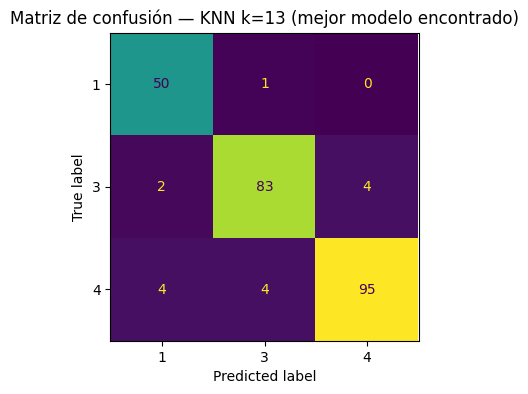

In [ ]:
best_pipe = Pipeline([("tfidf", TfidfVectorizer()), ("knn", KNeighborsClassifier(n_neighbors=13))])
evaluar_knn(best_pipe, X_train, y_train, X_test, y_test, titulo="KNN k=13 (mejor modelo encontrado)")

Finalmente usamos GridSearchCV para encontrar los mejores hiperparámetros del modelo KNN, seleccionarlos y dar el mejor modelo.

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores hiperparámetros: {'knn__metric': 'minkowski', 'knn__n_neighbors': 21, 'knn__p': 2, 'knn__weights': 'uniform'}
Mejor score de CV (train): 0.9598

=== Mejor modelo (GridSearch) ===
Accuracy (test): 0.9567
ROC AUC (test): 0.996

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.93      0.95      0.94       101
           3       0.97      0.95      0.96       179
           4       0.96      0.97      0.96       205

    accuracy                           0.96       485
   macro avg       0.95      0.96      0.95       485
weighted avg       0.96      0.96      0.96       485



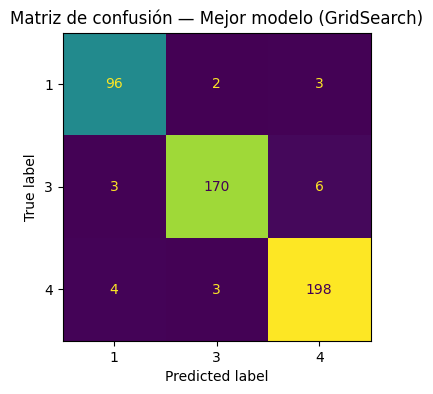

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold


pipe = Pipeline([
    ("tfidf", TfidfVectorizer()), 
    ("knn", KNeighborsClassifier())
])

param_grid = {
    "knn__n_neighbors": [1, 3, 5, 7, 13, 15, 21, 31],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["minkowski"],
    "knn__p": [1, 2], 
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy", 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    refit=True,
    verbose=1
)

grid.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor score de CV (train):", round(grid.best_score_, 4))

best_knn = grid.best_estimator_
evaluar_knn(best_knn, X_train, y_train, X_test, y_test, titulo="Mejor modelo (GridSearch)")


### **Resultados y modelo aplicado sobre datos de prueba**
Tras tener un modelo ya usable, procederemos a hacer la ejecución del codigo sobre el campo de pruebas para categorizar los textos.

In [64]:
def cargar_datos(file: str):
    df_prueba = pd.read_excel(file)
    df_prueba = df_prueba.rename(columns={"Textos_espanol": "textos"})
    df_prueba['textos'] = df_prueba['textos'].astype("string")
    todoAmin(df_prueba)
    limpiza(df_prueba)
    verNulosYDuplicados(df_prueba)
    df_prueba = tokenizacion(df_prueba)   
    quitar_stopwords(df_prueba)
    df_prueba =lematizar_tokens(df_prueba)


    df_prueba = lematizar_tokens(df_prueba)
    df_prueba['lematizados_str'] = df_prueba['lematizados'].apply(lambda tokens: ' '.join(tokens))
    return df_prueba

df_prueba = cargar_datos('Datos_prueba.xlsx')
df_prueba.head()

Valores nulos por columna:


textos    0
dtype: int64


Duplicados (filas completas): 0
Columnas constantes: Ninguna


,textos,tokens,tokens_sin_innecesarios,lematizados,lematizados_str
0,el rector que es el representante local del mi...,"[el, rector, que, es, el, representante, local...","[rector, representante, local, ministerio, edu...","[rector, representante, local, ministerio, edu...",rector representante local ministerio educació...
1,tenga en cuenta que todos los programas antipo...,"[tenga, en, cuenta, que, todos, los, programas...","[programas, antipobreza, condiciones, caracter...","[programa, antipobrezar, condición, caracteriz...",programa antipobrezar condición caracterizado ...
2,debido a que son en gran medida invisibles est...,"[debido, a, que, son, en, gran, medida, invisi...","[medida, invisibles, formas, trabajo, infantil...","[medida, invisible, forma, trabajo, infantil, ...",medida invisible forma trabajo infantil difíci...
3,los recursos aún son limitados en este sector ...,"[los, recursos, aún, son, limitados, en, este,...","[recursos, limitados, sector, servicios, priva...","[recurso, limitado, sector, servicio, privado,...",recurso limitado sector servicio privado fin l...
4,durante el período 1985-2008 la educación prim...,"[durante, el, período, 1985-2008, la, educació...","[período, 1985-2008, educación, primaria, secu...","[período, 1985-2008, educación, primario, secu...",período 1985-2008 educación primario secundari...


Ahora tras dejar los datos en el mismo formato de nuestro codigo, sacando las palabras lematizadas usaremos el mejor modelo, en este caso el de GridSearch ya que ofrece una buen ROC AUC, lo cual indica que tan bien clasifica los datos el modelo.

In [80]:
X_prueba = df_prueba["lematizados_str"]
y_pred = best_knn.predict(X_prueba)

df_prueba["prediccion"] = y_pred
df_salida = df_prueba[["lematizados_str", "prediccion"]]
df_salida.to_excel("Resultados_prueba.xlsx", index=False)

print("Predicciones guardadas en Resultados_prueba.xlsx")

Predicciones guardadas en Resultados_prueba.xlsx
